# Clustering for house hunting in Berlin

Thiago de Carvalho - Berlin - Abril/2021

### Table of Contents <a id='toc'></a>


<br>
<font size = 2>

1.  <a href="#item1">Introduction</a>

2.  <a href="#item2">Set up</a>

3.  <a href="#item3">Data Acquisition and Cleaning</a>
    
4.  <a href="#item4">Preprocessing</a>

5.  <a href="#item5">Clustering neighbourhoods with K-means</a>     
    
6.  <a href="#item6">Finding narrower zones to househunting with DBSCAN</a>     
    
7.  <a href="#item7">Plotting Results with Folium</a>    
    
8.  <a href="#item8">Conclusion</a> 
    
    </font>
    </div>

## --> Introdution<a id='item1'></a>

Berlin is one of the main cities in the world. The German capital has embrace diversty and is considered by many a fascinating place to live. The cultural variety of its nearly 4 million inhabitants is reflected in its dozens of neighborhoods. The wide range of venues categories in each neighborhood make it singular and more attractive to a specific profile of inhabitant.

If on the one hand diversity brings the comfort of knowing that anyone will find an interesting place to live in the city like Berlin, on the other hand it makes it complex (especially challenging for a newcomer to the city) to find an apartment to rent that maximizes a resident's satisfaction.

By considering this problem in data science perspective, it is possible to target the search for a new resident to specific areas of the city using clustering techniques, public databases and a set of premises of attractiveness of venues.

It is important to point out that the analysis was intended (only and exclusively) to meet the couple's needs . In no way does the results serve as a ranking of the attractiveness of Berlin's neighborhoods. The actual data presented  showed that Germany's capital is a diverselly attractive and  really safe city to live.

The aim was to apply clustering methods (such as k-means and DBSCAN) in geodatabases to find house hunting prospective areas that meets the (just relocated to Berlin) couple's interests. For this purpose were needed the following databases:
  * Berlin 2020 venues by category geodata 
  * List of prioritary venues in the customer's perpective
  * Average rental prices by Berliners districts
  * Berlin’s neighbourhood geospatial data
  * 2019 Berlin Crimes by neighbourhood


## --> Set up -  Importing libraries <a id='item2'></a>

In [1]:
import geopandas as gpd # Library to work with geospatial data 
import pandas as pd # Library for data analsysis
import numpy as np # Library to handle data in a vectorized manner

# Plotting libraries
import matplotlib.pyplot as plt # Plotting library used for 2D graphics
import plotly.express as px # Plotting library to create entire figures at once
from pandas.plotting import parallel_coordinates # Plotting library to visualize clusters

import json # library to handle JSON files
from geopy import Nominatim# Library to locate the coordinates of addresses

import requests # Library to handle requests behind an API 

# Clustering libraries and metrics
from sklearn.cluster import KMeans 
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import folium # Map rendering library

## --> Data Acquisition and Cleaning <a id='item3'></a>

### Schema

|  |  | Input | Processes | Output |
| --- | :--- | :--- | :--- | :--- |
| A | Berlin's neighbourhood geospatial data| neigbourhoods.geojson | Read neibourhoods geodata file and add centroids | df_berlin_neighbourhoods_geo |
| B | Berlin's venues geospatial database| API Credentials <br> df_berlin_neighbourhoods_geo | Data extraction using foursquare developer API  | df_berlin_venues |
| C | 2019 Berlin crimes by neighbourhood| Berlin_crimes.csv | Read csv crimes records by neighbourhood | df_berlin_crimes_2019 |
| D | 2019 Berlin rent average prices | statistic_id800765_average-cost-of-rent-of-apartments-in-selected-districts-in-berlin-germany-2019.xlsx|  Read xlsx square metters average prices by district | df_berlin_avg_price_2019 |

### A)  Berlin's neighbourhood geospatial data   
    *Usage goal:   Get Berlin’s Neighbourhood multipolygons and coordinates 
    *Data source:  http://data.insideairbnb.com/germany/be/berlin/2021-02-20/visualisations/neighbourhoods.geojson
    *File Name:    neigbourhoods.geojson
    *Format:       geojson
    *Columns:       neigbourhood_group | neigbourhood | geometry

In [2]:
# Reading geojson file with geopandas 
df_berlin_neighbourhoods = gpd.read_file('neighbourhoods.geojson', encoding='utf-8')

# Removing null values and reseting the index
df_berlin_neighbourhoods = df_berlin_neighbourhoods[~ df_berlin_neighbourhoods['neighbourhood_group'].isnull()]\
                            .reset_index(drop=True)
df_berlin_neighbourhoods

,neighbourhood,neighbourhood_group,geometry
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52..."
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52..."
2,Wiesbadener Straße,Charlottenburg-Wilm.,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52..."
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,"MULTIPOLYGON (((13.70973 52.39630, 13.70926 52..."
4,Müggelheim,Treptow - Köpenick,"MULTIPOLYGON (((13.73762 52.40850, 13.73773 52..."
...,...,...,...
133,Hellersdorf-Ost,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.62135 52.52704, 13.62079 52..."
134,Mahlsdorf,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.65554 52.52982, 13.65693 52..."
135,Ost 1,Reinickendorf,"MULTIPOLYGON (((13.36666 52.55823, 13.36561 52..."
136,Ost 2,Reinickendorf,"MULTIPOLYGON (((13.36418 52.56298, 13.36423 52..."


#### Datacare: 
    A total of 11 small regions of the past were stored as a single neibourhood into a neibourhood polygon.
    They were stored splited by "/".
    For these cases we will use the first small region name as the name of the neibourhood.

In [3]:
# Dataframe to store splitted neighbourhood names
new = df_berlin_neighbourhoods["neighbourhood"].str.split("/", n = 1, expand = True)

# Finding the centroids with geopandas function coordenates of each neighbourhood multipolygon
df_berlin_neighbourhoods['Latitude'] = df_berlin_neighbourhoods['geometry'].centroid.y
df_berlin_neighbourhoods['Longitude'] = df_berlin_neighbourhoods['geometry'].centroid.x

# Replacing the 1st value to name each neighbourhood 
df_berlin_neighbourhoods["neighbourhood"]= new[0]
df_berlin_neighbourhoods

,neighbourhood,neighbourhood_group,geometry,Latitude,Longitude
0,Blankenfelde,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...",52.612536,13.400340
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52...",52.543687,13.418908
2,Wiesbadener Straße,Charlottenburg-Wilm.,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52...",52.472878,13.311817
3,Schmöckwitz,Treptow - Köpenick,"MULTIPOLYGON (((13.70973 52.39630, 13.70926 52...",52.375075,13.654120
4,Müggelheim,Treptow - Köpenick,"MULTIPOLYGON (((13.73762 52.40850, 13.73773 52...",52.407020,13.683591
...,...,...,...,...,...
133,Hellersdorf-Ost,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.62135 52.52704, 13.62079 52...",52.533194,13.613755
134,Mahlsdorf,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.65554 52.52982, 13.65693 52...",52.503018,13.617146
135,Ost 1,Reinickendorf,"MULTIPOLYGON (((13.36666 52.55823, 13.36561 52...",52.568726,13.371505
136,Ost 2,Reinickendorf,"MULTIPOLYGON (((13.36418 52.56298, 13.36423 52...",52.573600,13.348588


Side note [1]: Hidden warning related to the precision of centroid coordenates that does not impact the analysis . You can check explanation and decision at the end of the notebook

In [4]:
# Creating a copy of the dataframe
df_berlin_neighbourhoods_geo = df_berlin_neighbourhoods 
df_berlin_neighbourhoods_geo

,neighbourhood,neighbourhood_group,geometry,Latitude,Longitude
0,Blankenfelde,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...",52.612536,13.400340
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52...",52.543687,13.418908
2,Wiesbadener Straße,Charlottenburg-Wilm.,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52...",52.472878,13.311817
3,Schmöckwitz,Treptow - Köpenick,"MULTIPOLYGON (((13.70973 52.39630, 13.70926 52...",52.375075,13.654120
4,Müggelheim,Treptow - Köpenick,"MULTIPOLYGON (((13.73762 52.40850, 13.73773 52...",52.407020,13.683591
...,...,...,...,...,...
133,Hellersdorf-Ost,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.62135 52.52704, 13.62079 52...",52.533194,13.613755
134,Mahlsdorf,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.65554 52.52982, 13.65693 52...",52.503018,13.617146
135,Ost 1,Reinickendorf,"MULTIPOLYGON (((13.36666 52.55823, 13.36561 52...",52.568726,13.371505
136,Ost 2,Reinickendorf,"MULTIPOLYGON (((13.36418 52.56298, 13.36423 52...",52.573600,13.348588


### B)  Berlin's venues geospatial database 
    *Usage goal:   Use foursquare api to identify potential neighbourhood that meet the briefing specifications.Generate a dataframe using the Latitude and longitude of each neighbourhood to store venues information.
                   
    *Data source: Foursquare developer API (https://developer.foursquare.com/)
    *Format:      json
    *Columns:     Neighbourhood | Venue | Venue_Latitude | Venue_Longitude | Venue Category

In [ ]:
#### Setting Foursquare Credentials and Version
CLIENT_ID = '#' # Foursquare ID
CLIENT_SECRET = '#' # Foursquare Secret
ACCESS_TOKEN = '#' # FourSquare Access Token
VERSION = '20201231' # date for the extraction
LIMIT = 100

# To know more about the API and how to get credential access: https://developer.foursquare.com/docs/places-api/

In [ ]:
#### Estabilishing a function to get top 100 venues of
#### all the neighbourhoods in Berlin within a radius of 1000 meters

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # creating the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # returning only relevant information for each nearby venue
        venues_list.append([(
            name, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    # Storing the results in a dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
# Executing the function to find venues for each neigbourhood using the set API credentials and the geodatabase  
berlin_venues_original = getNearbyVenues(names=df_berlin_neighbourhoods_geo['neighbourhood'],
                                   latitudes=df_berlin_neighbourhoods_geo['Latitude'],
                                   longitudes=df_berlin_neighbourhoods_geo['Longitude']
                                  )

In [ ]:
# Result of the function execution
berlin_venues_original

In [ ]:
# Storing result in a CSV.file
berlin_venues_original.to_csv(r'berlin_venues_2020.csv', index = False, encoding='utf-8')

In [5]:
# Running the analysis from the csv stored results as a dataframe with results to a .csv file
df_berlin_venues = pd.read_csv('berlin_venues_2020.csv', sep=',', encoding='utf-8')
df_berlin_venues

,Neighbourhood,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Blankenfelde,Botanischer Volkspark Pankow,52.605732,13.395381,Botanical Garden
1,Blankenfelde,Café mint*,52.603944,13.397227,Café
2,Blankenfelde,Café Traktorista,52.617838,13.392783,Café
3,Blankenfelde,Steckenpferd Blankenfelde,52.619083,13.393721,Café
4,Blankenfelde,Wintec Autoglas - Detlef Lindner,52.619594,13.394978,Automotive Shop
...,...,...,...,...,...
6215,MV 2,Tchibo Prozente,52.607601,13.323242,Warehouse Store
6216,MV 2,Seggeluchbecken,52.604465,13.348119,Park
6217,MV 2,S+U Wittenau,52.595761,13.336062,Light Rail Station
6218,MV 2,S Waidmannslust,52.606687,13.320851,Light Rail Station


### C)  2019 Berlin crimes database by neighbourhood
    * Usage goal:   Identify potential neighbourhood that meet the briefing expectations in terms of safety.
    * Data source:  https://www.kaggle.com/danilzyryanov/crime-in-berlin-2012-2019/download
    * Description:  Kaggle's Berlin Crimes data series, fields translated from German to English 
    * Source:       Berlin's Kommissariat - 
                    Collection methodology: XLSX-document had books separated by year. 
                    They were united to the single CSV and year-column addition made. 
                    https://www.berlin.de/polizei/service/kriminalitaetsatlas/)
    * File Name:    Berlin_crimes.csv
    * Format:       csv
    * Columns:      Year | District | Code | Location | Robbery | Street_robbery | Injury | Agg_assault | Threat | Theft | Car | From_car | Bike | Burglary | Fire | Arson | Damage | Graffiti | Drugs | Local

In [6]:
# Assigning the csv to a dataframe
df_berlin_crimes = pd.read_csv('Berlin_crimes.csv', sep=',', encoding='utf-8')
df_berlin_crimes

,Year,District,Code,Location,Robbery,Street_robbery,Injury,Agg_assault,Threat,Theft,Car,From_car,Bike,Burglary,Fire,Arson,Damage,Graffiti,Drugs,Local
0,2012,Mitte,10111,Tiergarten Süd,70,46,586,194,118,2263,18,328,120,68,16,4,273,26,171,1032
1,2012,Mitte,10112,Regierungsviertel,65,29,474,123,142,3203,10,307,170,37,10,4,380,124,98,870
2,2012,Mitte,10113,Alexanderplatz,242,136,1541,454,304,8988,81,792,822,275,49,27,1538,522,435,3108
3,2012,Mitte,10114,Brunnenstraße Süd,52,25,254,60,66,1916,86,192,396,131,14,5,428,122,213,752
4,2012,Mitte,10221,Moabit West,130,51,629,185,199,2470,94,410,325,161,42,22,516,64,259,1403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,2019,Reinickendorf,123012,Nord 2 - Waidmannslust/Wittenau/Lübars,34,19,372,85,123,1160,30,135,150,93,16,3,306,74,110,728
1196,2019,Reinickendorf,123021,MV 1 - Märkisches Viertel,42,22,491,123,187,1100,51,224,76,40,39,19,286,11,73,986
1197,2019,Reinickendorf,123022,MV 2 - Rollbergsiedlung,6,4,84,19,34,293,13,36,18,34,5,2,156,56,21,212
1198,2019,Reinickendorf,123043,West 3 - Borsigwalde/Freie Scholle,8,4,95,18,43,492,21,96,69,38,6,1,79,8,31,218


In [7]:
# Assigning the csv to a dataframe
df_berlin_crimes = pd.read_csv('Berlin_crimes.csv', sep=',', encoding='utf-8')

# Selecting only crime data of 2019
df_berlin_crimes_2019 = df_berlin_crimes[df_berlin_crimes['Year'] == 2019].reset_index(drop=True)

# Droppig unnecessary columns
df_berlin_crimes_2019.drop(columns=["Year", 'Code'],inplace=True)

df_berlin_crimes_2019

,District,Location,Robbery,Street_robbery,Injury,Agg_assault,Threat,Theft,Car,From_car,Bike,Burglary,Fire,Arson,Damage,Graffiti,Drugs,Local
0,Mitte,Tiergarten Süd,60,35,365,92,128,2271,15,198,296,55,13,6,347,77,231,980
1,Mitte,Regierungsviertel,42,20,554,136,152,3692,13,172,352,22,19,4,497,162,170,1057
2,Mitte,Alexanderplatz,173,102,1966,500,420,11233,63,587,940,137,43,12,1307,381,1133,3813
3,Mitte,Brunnenstraße Süd,40,29,268,64,79,1859,39,182,361,64,18,7,424,172,86,902
4,Mitte,Moabit West,66,29,685,210,202,2107,47,322,326,93,28,15,641,91,618,1409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Reinickendorf,Nord 2 - Waidmannslust/Wittenau/Lübars,34,19,372,85,123,1160,30,135,150,93,16,3,306,74,110,728
146,Reinickendorf,MV 1 - Märkisches Viertel,42,22,491,123,187,1100,51,224,76,40,39,19,286,11,73,986
147,Reinickendorf,MV 2 - Rollbergsiedlung,6,4,84,19,34,293,13,36,18,34,5,2,156,56,21,212
148,Reinickendorf,West 3 - Borsigwalde/Freie Scholle,8,4,95,18,43,492,21,96,69,38,6,1,79,8,31,218


##### !!!! MANUAL DATACARE ALERT !!!!
    Analyzing the difference of the amount of records it was necessary to verify the difference between:
        df_berlin_neighbourhoods_geo.neighbourhood (138 neighbourhoods)
        df_berlin_crimes_2019.Location (150 neighbourhoods)
    From this difference analysis came out:
        a) The diagnosis that the crime database carried extra records for each District 
           in order to record crimes that did not have their neighborhood specified. 
           (e.g. Bezirk (Rd), nicht zuzuordnen - District (Rd), not assignable)
           Those records won't be used in this analysis for the sake of simplicity.
        b) An auxiliary excel file that corrected typing errors of Location names, that we will used to fix
           the merge key. The database is provided with this notebook.

In [8]:
# Assigning a dataframe to store auxiliary excel file that corrected typing errors of Location names
neibourhood_data_care = pd.read_excel('neigh_cleansed.xlsx')
neibourhood_data_care

,Location,neighbourhood
0,Adlershof,Adlershof
1,Albrechtstr.,Albrechtstr.
2,Alexanderplatz,Alexanderplatz
3,Allende-Viertel,Allende-Viertel
4,Alt-Hohenschönhausen Nord,Alt-Hohenschönhausen Nord
...,...,...
145,"Bezirk (Rd), nicht zuzuordnen",Bezirk (Rd)
146,"Bezirk (Sp), nicht zuzuordnen",Bezirk (Sp)
147,"Bezirk (St-Zd), nicht zuzuordnen",Bezirk (St-Zd)
148,"Bezirk (Th-Sb), nicht zuzuordnen",Bezirk (Th-Sb)


In [9]:
# Inserting the corrected name into the crimes dataframe on a new column called 'neighbourhood'
df_berlin_crimes_2019 = df_berlin_crimes_2019.merge(neibourhood_data_care, on='Location', how='inner')
df_berlin_crimes_2019

,District,Location,Robbery,Street_robbery,Injury,Agg_assault,Threat,Theft,Car,From_car,Bike,Burglary,Fire,Arson,Damage,Graffiti,Drugs,Local,neighbourhood
0,Mitte,Tiergarten Süd,60,35,365,92,128,2271,15,198,296,55,13,6,347,77,231,980,Tiergarten Süd
1,Mitte,Regierungsviertel,42,20,554,136,152,3692,13,172,352,22,19,4,497,162,170,1057,Regierungsviertel
2,Mitte,Alexanderplatz,173,102,1966,500,420,11233,63,587,940,137,43,12,1307,381,1133,3813,Alexanderplatz
3,Mitte,Brunnenstraße Süd,40,29,268,64,79,1859,39,182,361,64,18,7,424,172,86,902,Brunnenstr. Süd
4,Mitte,Moabit West,66,29,685,210,202,2107,47,322,326,93,28,15,641,91,618,1409,Moabit West
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Reinickendorf,Nord 2 - Waidmannslust/Wittenau/Lübars,34,19,372,85,123,1160,30,135,150,93,16,3,306,74,110,728,Nord 2
146,Reinickendorf,MV 1 - Märkisches Viertel,42,22,491,123,187,1100,51,224,76,40,39,19,286,11,73,986,MV 1
147,Reinickendorf,MV 2 - Rollbergsiedlung,6,4,84,19,34,293,13,36,18,34,5,2,156,56,21,212,MV 2
148,Reinickendorf,West 3 - Borsigwalde/Freie Scholle,8,4,95,18,43,492,21,96,69,38,6,1,79,8,31,218,West 3


#### D)  2019 Berlin rent average prices
      * Goal:    To add prices per square meters perspective to drive decisions in terms of budget.
      * Source:  https://www.statista.com/statistics/800765/rent-expenditure-apartments-berlin-germany-by-district/
      * Descrip: Average asking rent of apartments in Berlin, Germany in 2019, by district(in euro per sq meter) In 2019, Berlin Mitte was the most expensive district for apartment rentals with an average a sking basic rent of 13.45 euros per square meter (excluding extra costs). The average for the city in this period was 10.45 euros per squared meter.  
      * File Name:   average-cost-of-rent-of-apartments-in-districts-berlin-germany-2019
      * Format:      xlsx
      * Columns:     District | Avg_price

In [10]:
# Assigning a dataframe to store  excel file with average prices per district
df_berlin_avg_price_2019 = pd.read_excel('average-cost-of-rent-of-apartments-in-districts-berlin-germany-2019.xlsx')
df_berlin_avg_price_2019

,District,avg_price
0,Charlottenburg-Wilm.,12.63
1,Friedrichshain-Kreuzberg,13.01
2,Lichtenberg,9.27
3,Marzahn - Hellersdorf,7.90
4,Mitte,13.45
5,Neukölln,10.10
6,Pankow,10.96
7,Reinickendorf,9.42
8,Spandau,8.86
9,Steglitz - Zehlendorf,10.70


## --> Preprocessing <a id='item4'></a>

### Schema

|  |  | Input | Processes | Output |
| --- | :--- | :--- | :--- | :--- |
| A | Priority venues | df_berlin_venues <br> Customer priority venues | The customer set the priority venues for the four categories: Facilities, Sport, Social and Food | df_priority_areas |
| B | Crime_index | df_berlin_crimes_2019 | Grouping crimes by neigbourhoods | df_berlin_crimes_2019 |
| C | Average prices| df_berlin_avg_price_2019 | Preparing for the merge | df_berlin_avg_price_2019 |
| D | Geodatabase full | df_berlin_neighbourhoods_geo | Merge information in a single geodataframe, geodata, , priority venues, average price and crime index  | df_berlin_neighbourhoods_geo_crime |

### A) Priority venues

In [11]:
# Generating a list of possible venues categories in Berlin
list_of_venues = df_berlin_venues.groupby('Venue Category').sum().reset_index()
list_of_venues = list_of_venues['Venue Category'].to_list()

In [12]:
# Setting priority venues (by the customer's perspective) to identify prospective neighbourhoods to live
df_berlin_venues['Facilities'] = 0
df_berlin_venues['Social'] = 0
df_berlin_venues['Sport'] = 0
df_berlin_venues['Food'] = 0

# Using the list_of_venues above the customer set which venues categories were the priority 

facilities = ['Train Station','Supermarket','Stationery Store','Metro Station','Light Rail Station','Drugstore']
sport = ['Yoga Studio','Trail','Track','Park','Mountain','Dance Studio','Board Shop','Bike Shop',
         'Bike Rental / Bike Share','Gym / Fitness Center','Gym']
social = ['Wine Shop','Wine Bar','Waterfront','Science Museum','Rock Club','Planetarium','Perfume Shop',
          'Outdoor Sculpture','Nightclub','Music Venue','Music Store','Monument / Landmark','Indie Theater',
          'Indie Movie Theater','Hotel Bar','Historic Site','Gay Bar','Gastropub','Concert Hall', 'Art Gallery', 
          'Beer Store','Beer Garden','Breakfast Spot','Bookstore','Arts & Crafts Store','Cultural Center','Garden',
          'Exhibit']
food = ['Vegetarian / Vegan Restaurant','Tea Room','Salad Place','Middle Eastern Restaurant','Falafel Restaurant',
        'Empanada Restaurant','Dumpling Restaurant','Donut Shop','Dive Bar','Distillery','Deli / Bodega',
        'Dim Sum Restaurant','Brazilian Restaurant','Beer Bar','Bar','Bagel Shop','Coffee Shop',
        'Chocolate Shop','Cheese Shop','Candy Store']


# Assigning grades/priority categories to the database
for n in facilities:
    filter = (df_berlin_venues['Venue Category'] == n) 
    df_berlin_venues.loc[filter,'Facilities'] = 1   

for n in social:
    filter = (df_berlin_venues['Venue Category'] == n) 
    df_berlin_venues.loc[filter,'Social'] = 1

for n in sport:
    filter = (df_berlin_venues['Venue Category'] == n) 
    df_berlin_venues.loc[filter,'Sport'] = 1

for n in food:
    filter = (df_berlin_venues['Venue Category'] == n) 
    df_berlin_venues.loc[filter,'Food'] = 1   

df_berlin_venues.head()

,Neighbourhood,Venue,Venue Latitude,Venue Longitude,Venue Category,Facilities,Social,Sport,Food
0,Blankenfelde,Botanischer Volkspark Pankow,52.605732,13.395381,Botanical Garden,0,0,0,0
1,Blankenfelde,Café mint*,52.603944,13.397227,Café,0,0,0,0
2,Blankenfelde,Café Traktorista,52.617838,13.392783,Café,0,0,0,0
3,Blankenfelde,Steckenpferd Blankenfelde,52.619083,13.393721,Café,0,0,0,0
4,Blankenfelde,Wintec Autoglas - Detlef Lindner,52.619594,13.394978,Automotive Shop,0,0,0,0


In [13]:
# Grouping the priority venues by neighbourhood

# Grouping the results by Neighbourhood and sum results
df_priority_areas = df_berlin_venues.groupby('Neighbourhood').sum().reset_index()

# Droppig unnecessary columns
df_priority_areas.drop(columns=["Venue Latitude", 
                                "Venue Longitude"],inplace=True)

# Renaming column to match with the column name of dataframe with geodata 
df_priority_areas.rename(columns={'Neighbourhood':'neighbourhood'}, inplace=True)


df_priority_areas.head()

,neighbourhood,Facilities,Social,Sport,Food
0,Adlershof,5,0,2,1
1,Albrechtstr.,3,1,2,0
2,Alexanderplatz,1,19,5,6
3,Allende-Viertel,4,0,0,0
4,Alt Treptow,5,10,6,5


### B) Crime_index

In [14]:
# Creating a crime_idx column and setting the values on a scale from 0 to 1
df_berlin_crimes_2019['crime_idx']= df_berlin_crimes_2019.sum(axis=1)

# Selecting the necessary columns: Location (that is the neighbourhood name) and crime_idx
df_berlin_crimes_2019 = df_berlin_crimes_2019[['neighbourhood','crime_idx']]
df_berlin_crimes_2019

,neighbourhood,crime_idx
0,Tiergarten Süd,5169
1,Regierungsviertel,7064
2,Alexanderplatz,22810
3,Brunnenstr. Süd,4594
4,Moabit West,6889
...,...,...
145,Nord 2,3438
146,MV 1,3770
147,MV 2,993
148,West 3,1227


### C) Average prices

In [15]:
# Renaming column to match with the column name of dataframe with geodata 
df_berlin_avg_price_2019.rename(columns={'District':'neighbourhood_group'}, inplace=True)
df_berlin_avg_price_2019

,neighbourhood_group,avg_price
0,Charlottenburg-Wilm.,12.63
1,Friedrichshain-Kreuzberg,13.01
2,Lichtenberg,9.27
3,Marzahn - Hellersdorf,7.90
4,Mitte,13.45
5,Neukölln,10.10
6,Pankow,10.96
7,Reinickendorf,9.42
8,Spandau,8.86
9,Steglitz - Zehlendorf,10.70


### D) Geodatabase full

In [16]:
# Adding the Priority venues into geodatabase dataframe.
df_berlin_neighbourhoods_geo = df_berlin_neighbourhoods.merge(df_priority_areas, 
                                                              how='left', on='neighbourhood')

In [17]:
# Merging geodata database with crimes.
df_berlin_neighbourhoods_geo_crime = df_berlin_neighbourhoods_geo.merge(df_berlin_crimes_2019, 
                                                                        on='neighbourhood',how='inner')                                                         

In [18]:
# Merging geodata database with average prices.
df_berlin_neighbourhoods_geo_crime = df_berlin_neighbourhoods_geo_crime.merge(df_berlin_avg_price_2019, 
                                                                       on='neighbourhood_group',how='inner')

df_berlin_neighbourhoods_geo_crime.head()

,neighbourhood,neighbourhood_group,geometry,Latitude,Longitude,Facilities,Social,Sport,Food,crime_idx,avg_price
0,Blankenfelde,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...",52.612536,13.400340,0,0,0,0,1859,10.96
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52...",52.543687,13.418908,0,9,3,26,2527,10.96
2,Buch,Pankow,"MULTIPOLYGON (((13.46449 52.65055, 13.46457 52...",52.639055,13.472613,0,0,1,0,2187,10.96
3,Buchholz,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41215 52...",52.607296,13.430847,5,0,0,0,949,10.96
4,Karow,Pankow,"MULTIPOLYGON (((13.46311 52.60464, 13.46043 52...",52.612182,13.479597,7,0,0,0,1045,10.96


## --> Clustering neighbourhoods with K-means <a id='item5'></a>

"**k-means clustering** aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster. k-means clustering minimizes within-cluster variances (squared Euclidean distances)."

### Schema

|  |  | Input | Processes | Output |
| --- | :--- | :--- | :--- | :--- |
| A | k-means setup | df_berlin_neighbourhoods_geo_crime | Normalizing the data series | Clus_dataSet |
| B | Elbow method | Clus_dataSet  | Determining the number of clusters in a data set | K=3 or K=4 |
| C | Silhouette_score | Clus_dataSet | Measuring the separation distance between the resulting clusters | K=4 |
| D | Fitting K-means | K=4 <br> df_berlin_cluster| k-means execution, results plotting and storing  | df_cluster_plot <br> df_berlin_cluster |
| E | Cluster target definition | df_cluster_plot <br> df_berlin_cluster | Visual exploratory data Analysis and clustering decision making | df_targeted_neighbourhoods |
| F | Cluster's plotting | df_targeted_neighbourhoods | Assigning clustering results to the geodatabase and ploting map with the results | df_targeted_neighbourhoods |

### A) k-means setup

In [19]:
# Assigning a dataframente with the variables to be used on k-means Clistering
df_berlin_cluster = df_berlin_neighbourhoods_geo_crime[['neighbourhood','Facilities',
                                                        'Social','Sport','Food','crime_idx']]

In [20]:
# Using StandardScaler() to normalize the dataset in order to fit the k-means.
X = df_berlin_cluster.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)

#### Findind the best number of Clusters using two metrics: Elbow Method and Silhouette_score

### B) Elbow method

The **Elbow method** is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.

Text(0.5, 1.0, 'Elbow Method For Optimal k')

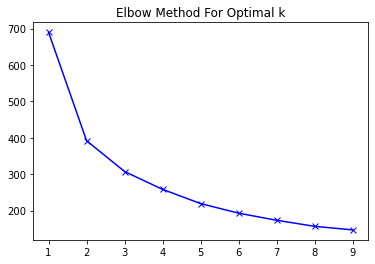

In [21]:
# Fitting the k-means with k being set from 1 to 10

sum_of_squared_distances = []

K = range(1,10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=179, n_init=20).fit(Clus_dataSet) #fitting k-means algorithm 20 times
    sum_of_squared_distances.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.title('Elbow Method For Optimal k')

### C) Silhouette_score

**Silhouette_score** measures the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually.

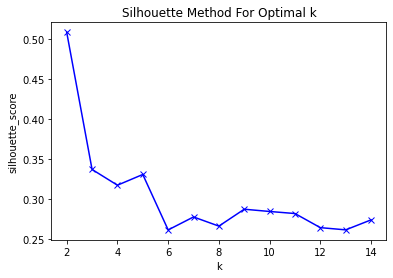

In [22]:
sil = []
K_sil = range(2,15)

for k in K_sil:
    kmeans = KMeans(n_clusters = k).fit(Clus_dataSet)
    labels = kmeans.labels_
    sil.append(silhouette_score(Clus_dataSet, labels, metric = 'euclidean', random_state=179))

plt.figure(figsize=(6, 4))
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

### D) Fitting K-means

Considering the dataset fitted, the optimal number of clusters should be between 2 to 5 clusters according to the **elbow method**.

    Observing the line there was not a relevant specific point, despite the k=2 that does not seem to be convenient to understand almost 140 neighbourhoods of a so diverse city as Berlin. In this case is convenient to check other metric, to decide about the number of clusters to pick.


The Silhouette score graph showed the optimal, again despite the k=2, that clustering in 5 groups bring more separate groups with slightly difference for 3 that also seemed small number of cluster as k=2.

    So, for the reasons described above and considering the results of the 2 metrics, the decision for the number of clusters was set to k=5 clusters.  



##### Kmeans = 5

In [23]:
# Applying k-means on the dataset
clusterNum = 5
k_means = KMeans(init = "random", n_clusters = clusterNum, n_init = 100, random_state = 179)
k_means.fit(X)
labels = k_means.labels_

# Assign the labels to each row in dataframe
df_berlin_cluster["Cluster"] = labels

In [24]:
# EXPLORATORY DATA ANALYSIS - Clusters plotting
df_cluster_plot = df_berlin_cluster.groupby('Cluster').mean().reset_index(drop=True)
df_cluster_plot.rename(columns={"Social": "Social_venues_average",
                                "Sport": "Sport_venues_average",
                                "Food": "Food_venues_average", 
                                "Facilities": "Facilities_venues_average",
                                "crime_idx":"Crime_idx_average"},inplace=True)
df_cluster_plot

,Facilities_venues_average,Social_venues_average,Sport_venues_average,Food_venues_average,Crime_idx_average
0,3.652174,6.826087,3.130435,7.478261,6117.695652
1,3.500000,0.750000,1.050000,1.000000,1595.316667
2,2.300000,10.700000,4.600000,16.200000,10144.600000
3,4.772727,2.522727,2.181818,3.409091,3592.022727
4,1.000000,19.000000,5.000000,6.000000,22810.000000


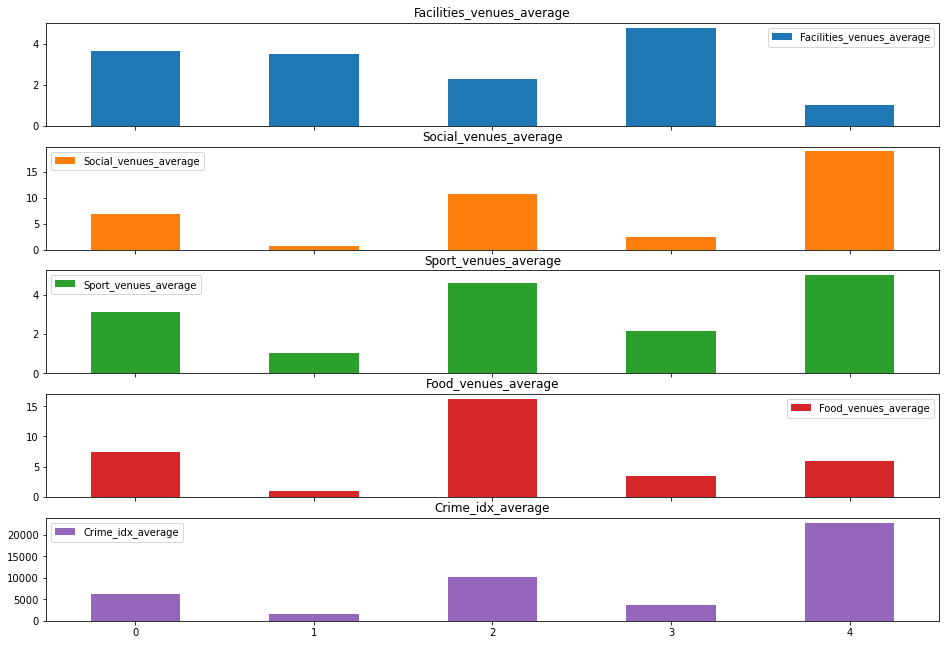

In [45]:
# Plotting average venues per cluster
axes = df_cluster_plot.plot.bar(rot=0, subplots=True)
#axes[1].legend(loc=0)
plt.rcParams['figure.figsize'] = [22, 11]
plt.show()

### E)  Cluster target definition

On the plot above we can see each cluster profile considering their mean in each variables of the model. Observing closely the cluster that were not chosen:

    * Cluster 2 – They are the less safe neighourhoods.
    * Clusters 0 and 1  - Although being the safer neighourhoods, they are not meeting significatively all dimensions the couple's need.

The chosen one:

    * Cluster 3 - Despite its moderate safety, it has really representatives averages on the 4 priority venues categories


In [26]:
# Taking a look at cluster labels
df_berlin_cluster.sort_values('Cluster').groupby('Cluster').count()

,neighbourhood,Facilities,Social,Sport,Food,crime_idx
Cluster,,,,,,
0,23,23,23,23,23,23
1,60,60,60,60,60,60
2,10,10,10,10,10,10
3,44,44,44,44,44,44
4,1,1,1,1,1,1


In [27]:
# Assigning the cluster to a dataframe 
df_targeted_neighbourhoods = df_berlin_cluster[['neighbourhood', 'Cluster']]

# Merging with the geodatabase
df_targeted_neighbourhoods = df_berlin_neighbourhoods_geo_crime.merge(df_targeted_neighbourhoods, 
                                                                           on='neighbourhood',how='inner')
# Storing results in a CSV.file
df_targeted_neighbourhoods.to_csv(r'targeted_neighbourhood.csv', index = False, encoding='utf-8')

df_targeted_neighbourhoods.head()

,neighbourhood,neighbourhood_group,geometry,Latitude,Longitude,Facilities,Social,Sport,Food,crime_idx,avg_price,Cluster
0,Blankenfelde,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...",52.612536,13.400340,0,0,0,0,1859,10.96,1
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52...",52.543687,13.418908,0,9,3,26,2527,10.96,1
2,Buch,Pankow,"MULTIPOLYGON (((13.46449 52.65055, 13.46457 52...",52.639055,13.472613,0,0,1,0,2187,10.96,1
3,Buchholz,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41215 52...",52.607296,13.430847,5,0,0,0,949,10.96,1
4,Karow,Pankow,"MULTIPOLYGON (((13.46311 52.60464, 13.46043 52...",52.612182,13.479597,7,0,0,0,1045,10.96,1


### F)  Cluster's plotting

In [28]:
# Setting cluster lables on the geodatabase
cluster_target = [2]
cluster_outofscope = [0,1,3,4]

for n in cluster_target:
    filter = (df_targeted_neighbourhoods['Cluster'] == n) 
    df_targeted_neighbourhoods.loc[filter,'Cluster'] = 'Targeted Neighbourhoods'
    
for n in cluster_outofscope:
    filter = (df_targeted_neighbourhoods['Cluster'] == n) 
    df_targeted_neighbourhoods.loc[filter,'Cluster'] = 'Out of scope Neigbourhoods'

# Visualizing the labeling result 
df_targeted_neighbourhoods.groupby('Cluster').count()

,neighbourhood,neighbourhood_group,geometry,Latitude,Longitude,Facilities,Social,Sport,Food,crime_idx,avg_price
Cluster,,,,,,,,,,,
Out of scope Neigbourhoods,128,128,128,128,128,128,128,128,128,128,128
Targeted Neighbourhoods,10,10,10,10,10,10,10,10,10,10,10


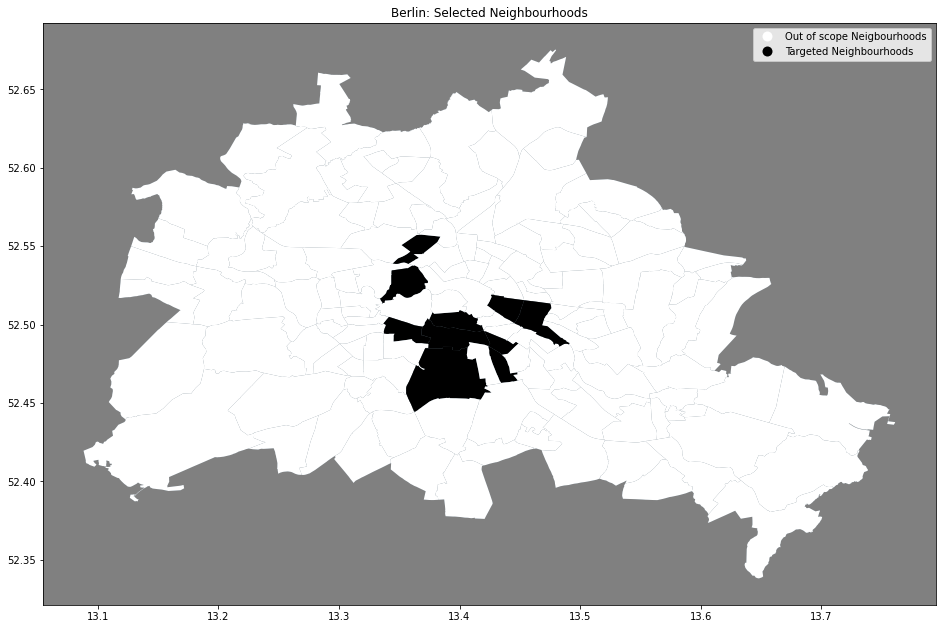

In [29]:
# Plotting the map with the target neighbourhoods 

plt.rcParams['figure.figsize'] = [16, 11]
fig, ax = plt.subplots()


df_berlin_neighbourhoods.plot(
    ax=ax, 
    alpha=0.2
)

df_targeted_neighbourhoods.plot(
    ax=ax,
    column='Cluster',
    categorical=True, 
    legend=True, 
    cmap='CMRmap_r',
)


ax.set(
    title='Berlin: Selected Neighbourhoods', 
    aspect=1.3,
    facecolor='grey'
);

## --> Finding zones to househunting with DBSCAN<a id='item6'></a>

**To be more specific, and in order to guarantee that we will search in parts of the neighbourhood with higher concentration of venues** that meets the couple expectation we will find narrower househunting zones using DBSCAN.

    "DBSCAN (Density-Based Spatial Clustering of Applications with Noise) finds core samples 
    of high density and expands clusters from them. Good for data which contains clusters of similar density."
    https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

Starting from the targeted neighbourhood found previously, we will recover and plot all venues of these neighbourhoods and then we will realize were are the better zones to look for a flat that will meet the customer needs.  

In [30]:
# Creating a list with only targeted neighbourhood
target_list = df_targeted_neighbourhoods[['neighbourhood','Cluster']]
target_list = target_list.loc[target_list['Cluster'] == 'Targeted Neighbourhoods']
target_list = target_list['neighbourhood'].to_list()
target_list

['Südliche Friedrichstadt',
 'Tempelhofer Vorstadt',
 'Karl-Marx-Allee-Süd',
 'Frankfurter Allee Süd FK',
 'Wedding Zentrum',
 'Moabit Ost',
 'Schöneberg-Nord',
 'Tempelhof',
 'Neuköllner Mitte',
 'Reuterstraße']

In [31]:
# Assigning the cluster to venues database
df_berlin_venues['Priority_index'] = (df_berlin_venues['Facilities'] +
                                      df_berlin_venues['Sport']+
                                      df_berlin_venues['Social']+
                                      df_berlin_venues['Food'])
df_berlin_venues['Target'] = 0

for n in target_list:
    filter = (df_berlin_venues['Neighbourhood'] == n) 
    df_berlin_venues.loc[filter,'Target'] = 1

In [32]:
# Creating a dataframe with venues placed only in the targeted neighbourhood area
target_neighbourhood_berlin_venues = df_berlin_venues.loc[(df_berlin_venues['Target'] != 0)
                                                       &(df_berlin_venues['Priority_index'] != 0)]

# Renaming columns
target_neighbourhood_berlin_venues.rename(columns={"Venue Latitude": 'Lat',
                                                   "Venue Longitude": "Long", 
                                                   "Neighborhood Longitude":"Neighbourhood Longitude"}
                                                  ,inplace=True)

# Reseting the index 
target_neighbourhood_berlin_venues.reset_index(drop=True)

,Neighbourhood,Venue,Lat,Long,Venue Category,Facilities,Social,Sport,Food,Priority_index,Target
0,Wedding Zentrum,Basalt,52.550840,13.360782,Bar,0,0,0,1,1,1
1,Wedding Zentrum,Café Cralle,52.550619,13.363449,Bar,0,0,0,1,1,1
2,Wedding Zentrum,Himmelbeet,52.547949,13.362341,Garden,0,1,0,0,1,1
3,Wedding Zentrum,Jatz,52.550327,13.368970,Bar,0,0,0,1,1,1
4,Wedding Zentrum,Kiki Sol,52.547590,13.368839,Bar,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
333,Tempelhof,Pausini,52.459449,13.383953,Coffee Shop,0,0,0,1,1,1
334,Tempelhof,S+U Tempelhof,52.470652,13.384738,Light Rail Station,1,0,0,0,1,1
335,Tempelhof,S46 S Westend <> Königs Wusterhausen,52.470950,13.384691,Light Rail Station,1,0,0,0,1,1
336,Tempelhof,Netto Marken-Discount,52.464445,13.376266,Supermarket,1,0,0,0,1,1


In [33]:
# Normalizinng geodata
labels_true = target_neighbourhood_berlin_venues[['Long','Lat']]
Xreal = target_neighbourhood_berlin_venues[['Long','Lat']]
X = StandardScaler().fit_transform(Xreal)
len(Xreal)

338

In [39]:
# Fitting DBSCAN and printing metrics

db = DBSCAN(eps=0.15, min_samples=13).fit(X) # lower eps and 13 venues as min_samples were set to assure high density

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 5
Estimated number of noise points: 206


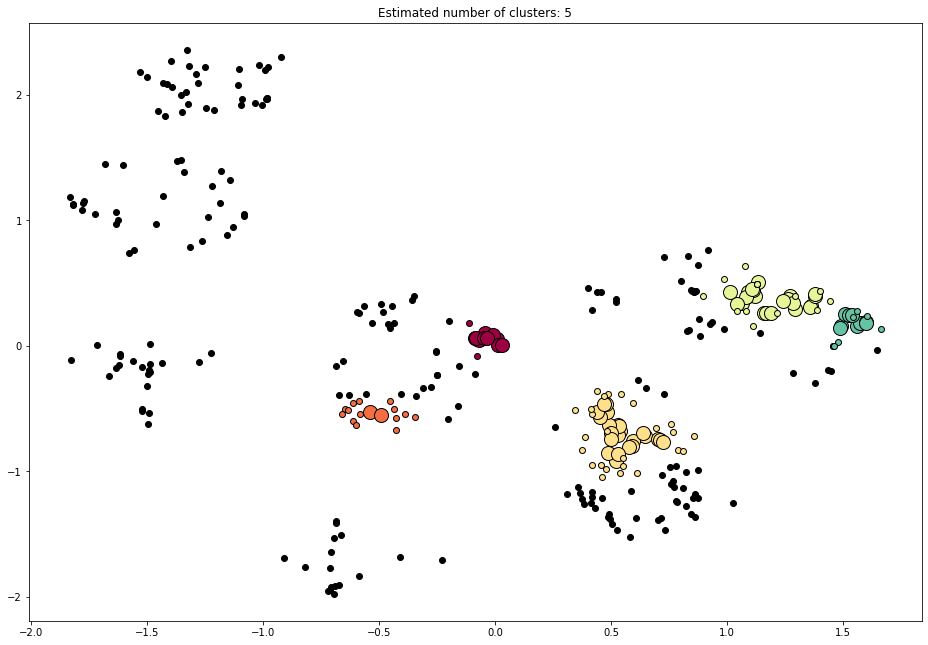

In [40]:
# Plotting the DBSCAN Results

# Black color removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

With DBSCAN the search areas for an apartment were restricted, the restriction was performed based on the concentration of items of preference. 

It's known that DBSCAN doesn't have any notion of centers of clusters as in KMeans. But, for plotting reasons, we will find the centroids of clusters found getting the mean of all the samples in a cluster.

In [41]:
target_neighbourhood_berlin_venues['DBSCAN_cluster'] = labels
foccus_zone = target_neighbourhood_berlin_venues.groupby('DBSCAN_cluster').mean().reset_index()

# Removing the "Cluster" with the noise
foccus_zone = foccus_zone[foccus_zone['DBSCAN_cluster'] != -1].reset_index(drop=True)
foccus_zone['DBSCAN_cluster'] = foccus_zone['DBSCAN_cluster'].apply(lambda x: f"Zone {x}")

foccus_zone = foccus_zone.drop(columns=['Priority_index', 'Target','Facilities', 'Social', 'Food', 'Sport'])
foccus_zone

,DBSCAN_cluster,Lat,Long
0,Zone 0,52.502968,13.408950
1,Zone 1,52.489859,13.390706
2,Zone 2,52.486165,13.431308
3,Zone 3,52.510057,13.455136
4,Zone 4,52.505177,13.468508


## --> Plotting results with Folium <a id='item7'></a>

In [42]:
# Finding the Berlin Location 
address = 'Berlin, German'

geolocator = Nominatim(user_agent="Berliner")
location = geolocator.geocode(address)
berlin_latitude = location.latitude
berlin_longitude = location.longitude

print('The geographical coordinate of Berlin are {}, {}.'.format(berlin_latitude, berlin_longitude))

The geographical coordinate of Berlin are 52.51865375, 13.376101367237903.


In [43]:
# creating city map of Berlin with the coordenates
map_berlin = folium.Map(location=[berlin_latitude, berlin_longitude], zoom_start=12)

In [44]:
# Ploting the neighbourhood polygons 
for _, r in df_targeted_neighbourhoods.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'yellow'})
    folium.Popup(str(r['avg_price'])).add_to(geo_j)
    geo_j.add_to(map_berlin)


# Instantiating a feature to group the foccus_zone found with DBSCAN 
foccus_zone_map = folium.map.FeatureGroup()


# Looping through the foccus_zone dataframe and add each to the feature created above
for lat, lng, label in zip(foccus_zone.Lat, foccus_zone.Long,foccus_zone.DBSCAN_cluster):
    foccus_zone_map.add_child(
        # Setting up the appearance of the foccus_zones to the map
        folium.features.CircleMarker( 
            [lat, lng],
            radius=15,
            popup = str(label),
            color='blue',
            color_opacity=0.3,
            fill=True,
            fill_color='blue',
            fill_opacity=0.3
        )
    )

    
    
# adding the foccus_zones to main_map
map_berlin.add_child(foccus_zone_map)

    
    
map_berlin

**By clicking on the map its prossible say that, considereing the lower prices of avarage square meters, the target Zones for the househunting of this couple are Zones 1 and 2** 

## --> Conclusion<a id='item8'></a>

Considering the results presented above in the analysis the couple's apartment search, clustering methods applied to geodata were satisfactory, reducing from 138 to 5 mainly desirable/priority zones for the couple.

Taking into consideration the average price per square meter of the properties for rent in these neighborhoods, the search should prioritize the areas marked on the map, starting from the cheapest one more to the south-center of Berlin. 

**It is important to point out that the exercise is intended to meet the couple's needs (only and exclusively). In no way does the analysis serve as a comparison of the attractiveness of Berlin's neighborhoods. The actual data presented here show that Germany's capital is an attractive and safe city.**


#### Project evolution
As an end user needs, would be necessary apply some Web scrapping techniques for searching data from announced flats.

As insights for future evolutions of this project, thinking about develop a front-end application as a commercial plugin for current house hunting websites:

* Would be useful developing a front end in order to allow anyone to easily set up the priority venues parameters.
* Using machine learning algorithms to calculate by a specific location the adherence to the set parameters.
* Addition of variables such price and all related characteristics of the flats (size, number of rooms, etc).


#### Side notes:

[1] Considering that we are using a multipolygon object it can interfere at the precision to locate centroides in a cartesian plan. But as we don't need to be extremely precise in this part of the analysis, we will ignore the warning.
    https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.GeoSeries.to_crs.html
    
    Warning Suggestion --> df_berlin_neighbourhoods['geometry'].to_crs(3857).centroid
    Decision --> df_berlin_neighbourhoods['geometry'].centroid (ESPG 4326 used here)
    EPSG:4326 is in degrees - 3D sphere, that uses a coordinate system the same as a GLOBE (curved surface). 
    EPSG:3857 is in metres - 2D projection,that uses a coordinate system the same as a MAP (flat surface).